# Génération des attributs à partir des descriptions
- model text-bison few-shot prompting

## Setup Project

In [2]:


%pip install google-cloud-aiplatform>=1.31.0 

Note: you may need to restart the kernel to use updated packages.


In [1]:

import vertexai
from google.cloud import bigquery
from tools import *
from bq import save_bq


PROJECT_ID = "ml-demo-384110"  # @param {type:"string"}
vertexai.init(project=PROJECT_ID, location="us-central1")
client = bigquery.Client(project=PROJECT_ID)
bucket = "ml-demo-384110-bucket"

%load_ext google.cloud.bigquery

In [ ]:
%%bigquery

create or replace table `ml-demo-384110.immo_us_enriched.vc_embeddings_multilangual` as 
(
select
ml_results.ml_generate_text_llm_result as attributes ,
bool(ml_generate_text_rai_result['blocked']) AS blocked,
ml_generate_text_rai_result['categories'] AS blocked_categories,
ml_generate_text_status,
uri,
caption_en, prompt
#Id
FROM ML.GENERATE_TEXT(
MODEL `immo_us_enriched.bqml-llm_model`,
(
SELECT uri, caption_en,
CONCAT(
'You are a realestate agent, you know how to extract ATTRIBUTES of real estate property from DESCRIPTION. ',
#'If the photo description is not clear return "N/A" ',
'You use only information provided in the DESCRIPTION to extract ATTRIBUTES. ', 
#'Use these examples as reference: ',

# exemple 1
'.\n DESCRIPTION: Warm and inviting bedroom in a cozy home with wood floors, comfortable furniture and lots of natural light.',
'.\n ATTRIBUTES: Furniture, Property, Window, Wood, Picture frame, Comfort, Fixture, Interior design, Lighting, Building',


# exemple 2
'.\n DESCRIPTION: A residential real estate property with a porch, a garden with beautiful plants and a car park spot in front.',
'.\n ATTRIBUTES: Wheel, Plant, Tire, Car, Sky, Vehicle, Building, Motor vehicle, Window, Residential area',


# exemple 3
'.\n DESCRIPTION: Floor plan of the first floor with the detail of the size of bedrooms, bathroom,',
'.\n ATTRIBUTES: Technical drawing, Slope, Floor plan, bedroom, bathroom, first floor.',

# Question
".\n DESCRIPTION: ", caption_en, 
'.\n ATTRIBUTES: '


) AS prompt
FROM `immo_us_enriched.vqa_embeddings_multimodal_distance2` 
),
STRUCT(0.1 AS temperature,
1000 AS max_output_tokens,
1.0 AS top_p,
10 AS top_k,
TRUE AS flatten_json_output)
) as ml_results
)


In [21]:
%%bigquery

MERGE `ml-demo-384110.immo_us_enriched.vc_embeddings_multilangual` T
USING (
  select
ml_results.ml_generate_text_llm_result as attributes ,
bool(ml_generate_text_rai_result['blocked']) AS blocked,
ml_generate_text_rai_result['categories'] AS blocked_categories,
ml_generate_text_status,
uri,
caption_en, prompt
#Id
FROM ML.GENERATE_TEXT(
MODEL `immo_us_enriched.bqml-llm_model`,
(
SELECT uri, caption_en,
CONCAT(
'You are a realestate agent, you know how to extract ATTRIBUTES of real estate property from DESCRIPTION. ',
#'If the photo description is not clear return "N/A" ',
'You use only information provided in the DESCRIPTION to extract ATTRIBUTES. ', 
#'Use these examples as reference: ',


# exemple 1
'.\n DESCRIPTION: Warm and inviting bedroom in a cozy home with wood floors, comfortable furniture and lots of natural light.',
'.\n ATTRIBUTES: Furniture, Property, Window, Wood, Picture frame, Comfort, Fixture, Interior design, Lighting, Building',


# exemple 2
'.\n DESCRIPTION: A residential real estate property with a porch, a garden with beautiful plants and a car park spot in front.',
'.\n ATTRIBUTES: Wheel, Plant, Tire, Car, Sky, Vehicle, Building, Motor vehicle, Window, Residential area',


# exemple 3
'.\n DESCRIPTION: Floor plan of the first floor with the detail of the size of bedrooms, bathroom,',
'.\n ATTRIBUTES: Technical drawing, Slope, Floor plan, bedroom, bathroom, first floor.',


# exemple 4


# Question
".\n DESCRIPTION: ", caption_en, 
'.\n ATTRIBUTES: '


) AS prompt
  FROM `ml-demo-384110.immo_us_enriched.vc_embeddings_multilangual` WHERE ml_generate_text_status <> '' or blocked = True
),
STRUCT(0.1 AS temperature,
1000 AS max_output_tokens,
1.0 AS top_p,
10 AS top_k,
TRUE AS flatten_json_output)
) as ml_results
 
  
) S
ON T.prompt = S.prompt
WHEN MATCHED AND T.ml_generate_text_status <> '' THEN
  UPDATE SET T.attributes = S.attributes,
  T.ml_generate_text_status = S.ml_generate_text_status,
  T.blocked = S.blocked,
  T.blocked_categories = S.blocked_categories
WHEN MATCHED THEN
  DELETE
;





Query is running:   0%|          |

""


## Analyse results

In [22]:
%%bigquery df

select * from `ml-demo-384110.immo_us_enriched.vc_embeddings_multilangual` 

Query is running:   0%|          |

Downloading:   0%|          |

In [23]:
df.describe()


,attributes,blocked,blocked_categories,ml_generate_text_status,uri,caption_en,prompt
count,610,609,609,610,610,610,610
unique,570,1,6,1,574,556,556
top,"Sign, Word, Picture, Hosman..",False,"[""Legal""]",,gs://ml-demo-384110-bucket/dataset/immo/images/_210591_383642462_photos_3.jpg,the word hosman that is on a picture,"You are a realestate agent, you know how to extract ATTRIBUTES of real estate property from DESCRIPTION. You use only information provided in the DESCRIPTION to extract ATTRIBUTES. .\n DESCRIPTION: Warm and inviting bedroom in a cozy home with wood floors, comfortable furniture and lots of natural light..\n ATTRIBUTES: Furniture, Property, Window, Wood, Picture frame, Comfort, Fixture, Interior design, Lighting, Building.\n DESCRIPTION: A residential real estate property with a porch, a garden with beautiful plants and a car park spot in front..\n ATTRIBUTES: Wheel, Plant, Tire, Car, Sky, Vehicle, Building, Motor vehicle, Window, Residential area.\n DESCRIPTION: Floor plan of the first floor with the detail of the size of bedrooms, bathroom,.\n ATTRIBUTES: Technical drawing, Slope, Floor plan, bedroom, bathroom, first floor..\n DESCRIPTION: the word hosman that is on a picture.\n ATTRIBUTES:"
freq,6,609,496,610,8,6,6


In [7]:
df.describe()

,attributes,blocked,blocked_categories,ml_generate_text_status,uri,caption_en,prompt
count,610,610,609,611,611,611,611
unique,570,2,6,2,575,557,557
top,"Sign, Word, Picture, Hosman..",False,"[""Legal""]",,gs://ml-demo-384110-bucket/dataset/immo/images...,the word hosman that is on a picture,"You are a realestate agent, you know how to ex..."
freq,6,609,496,610,8,6,6


In [10]:
%%bigquery 

select * from `ml-demo-384110.immo_us_enriched.vc_embeddings_multilangual` where ml_generate_text_status = "RESOURCE_EXHAUSTED error occurred."


Query is running:   0%|          |

Downloading:   0%|          |

,attributes,blocked,blocked_categories,ml_generate_text_status,uri,caption_en,prompt
0,None,<NA>,None,RESOURCE_EXHAUSTED error occurred.,gs://ml-demo-384110-bucket/dataset/immo/images...,a bedroom with a large bed and a chair and the...,"You are a realestate agent, you know how to ex..."


In [9]:
df

,ml_generate_text_status
0,RESOURCE_EXHAUSTED error occurred.
1,


In [24]:
%%bigquery df
select * #distinct  string(blocked_categories[0])  
FROM `ml-demo-384110.immo_us_enriched.vc_embeddings_multilangual`  where string(blocked_categories[0]) in( "Illicit Drugs" , "Death, Harm & Tragedy")

Query is running:   0%|          |

Downloading:   0%|          |

In [25]:
pd.set_option('display.max_colwidth', None)

df

,attributes,blocked,blocked_categories,ml_generate_text_status,uri,caption_en,prompt
0,"Poster, Wall, Coca-cola, Room, Building, Interior design.",False,"[""Illicit Drugs"",""Legal""]",,gs://ml-demo-384110-bucket/dataset/immo/images/_picture_82502_82501425_159351249364514a7cae6504.25917119_1920.webp-original.jpg,a living room with a coca cola poster on the wall,"You are a realestate agent, you know how to extract ATTRIBUTES of real estate property from DESCRIPTION. You use only information provided in the DESCRIPTION to extract ATTRIBUTES. .\n DESCRIPTION: Warm and inviting bedroom in a cozy home with wood floors, comfortable furniture and lots of natural light..\n ATTRIBUTES: Furniture, Property, Window, Wood, Picture frame, Comfort, Fixture, Interior design, Lighting, Building.\n DESCRIPTION: A residential real estate property with a porch, a garden with beautiful plants and a car park spot in front..\n ATTRIBUTES: Wheel, Plant, Tire, Car, Sky, Vehicle, Building, Motor vehicle, Window, Residential area.\n DESCRIPTION: Floor plan of the first floor with the detail of the size of bedrooms, bathroom,.\n ATTRIBUTES: Technical drawing, Slope, Floor plan, bedroom, bathroom, first floor..\n DESCRIPTION: a living room with a coca cola poster on the wall.\n ATTRIBUTES:"
1,"Bed, Window, Building, Room, Furniture, Property.",False,"[""Death, Harm & Tragedy"",""Legal"",""Toxic""]",,gs://ml-demo-384110-bucket/dataset/immo/images/_picture_82422_82421909_15606774836453ea21446895.81398648_1920.webp-original.jpg,a bedroom with a bed and a window that says morts immobilier,"You are a realestate agent, you know how to extract ATTRIBUTES of real estate property from DESCRIPTION. You use only information provided in the DESCRIPTION to extract ATTRIBUTES. .\n DESCRIPTION: Warm and inviting bedroom in a cozy home with wood floors, comfortable furniture and lots of natural light..\n ATTRIBUTES: Furniture, Property, Window, Wood, Picture frame, Comfort, Fixture, Interior design, Lighting, Building.\n DESCRIPTION: A residential real estate property with a porch, a garden with beautiful plants and a car park spot in front..\n ATTRIBUTES: Wheel, Plant, Tire, Car, Sky, Vehicle, Building, Motor vehicle, Window, Residential area.\n DESCRIPTION: Floor plan of the first floor with the detail of the size of bedrooms, bathroom,.\n ATTRIBUTES: Technical drawing, Slope, Floor plan, bedroom, bathroom, first floor..\n DESCRIPTION: a bedroom with a bed and a window that says morts immobilier.\n ATTRIBUTES:"


,image,caption_en
0,,a living room with a coca cola poster on the wall
1,,a bedroom with a bed and a window that says morts immobilier

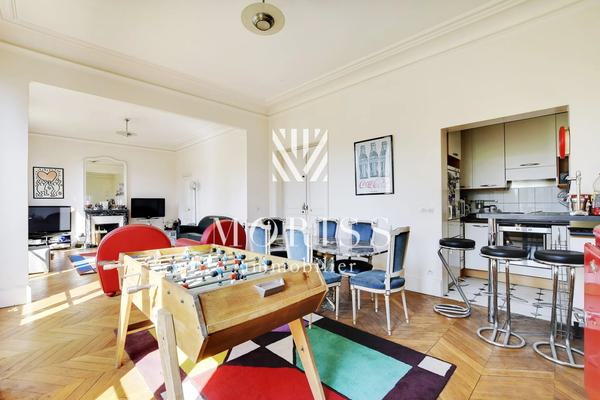
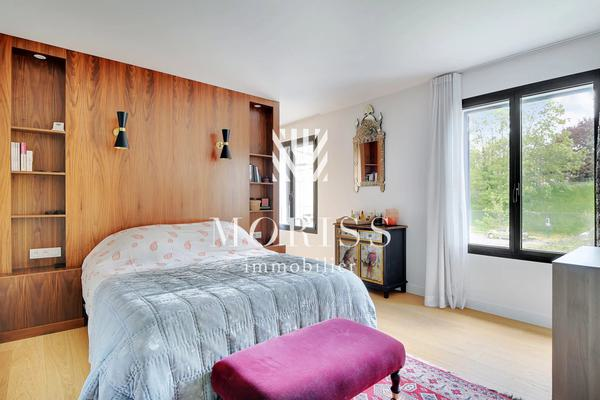

In [26]:
from tools import *

df_face_thumbnail = add_images_thumbnail_to_df(df,size=600)
# displaying PIL.Image objects embedded in dataframe
HTML(df_face_thumbnail[[ 'image', 'caption_en'
                         ]]

                        .to_html(formatters={'image': image_formatter}, escape=False))

## Compare attributes to vision attributes

In [4]:
%bigquery

create table  `ml-demo-384110.immo_us_enriched.vc_desc_to_attributes` as (
SELECT * from ML.GENERATE_TEXT_EMBEDDING(
  MODEL `ml-demo-384110.immo_us_enriched.bqml-gecko`,
  (
    SELECT attributes as content, attributes, caption_en, uri  from  `ml-demo-384110.immo_us_enriched.vc_embeddings_multilangual` m #limit 3
  ),
  STRUCT(TRUE AS flatten_json_output)
) attributes
);



SyntaxError: invalid decimal literal (1282110310.py, line 3)

In [7]:
%bigquery


create table  `ml-demo-384110.immo_us_enriched.vision_attributes` as (
  select * from 
ML.GENERATE_TEXT_EMBEDDING(
  MODEL `ml-demo-384110.immo_us_enriched.bqml-gecko`,
  (
    SELECT attributes as content, attributes,  uri  from  `immo_us_enriched.image_cloudvision_labels_1k_bench_3` m 
  ),
STRUCT(TRUE AS flatten_json_output)
) 

);






SyntaxError: invalid decimal literal (237929984.py, line 4)

In [2]:
%%bigquery df --project $PROJECT_ID

select distinct

ML.DISTANCE(
    vc.text_embedding ,
    v.text_embedding,
    'COSINE'
  ) AS distance_to_vision_vqa, 
  v.attributes attributes_vision ,
  vc.attributes  attributes_vc, caption_en description_vc,
  v.uri


 from  `ml-demo-384110.immo_us_enriched.vision_attributes` v, 
`ml-demo-384110.immo_us_enriched.vc_desc_to_attributes` vc
where v.uri = vc.uri
order by distance_to_vision_vqa

Query is running:   0%|          |

Downloading:   0%|          |

In [3]:
df.describe()

,distance_to_vision_vqa
count,599.000000
mean,0.199257
std,0.071898
min,0.055498
25%,0.141941
50%,0.197262
75%,0.247475
max,0.489100


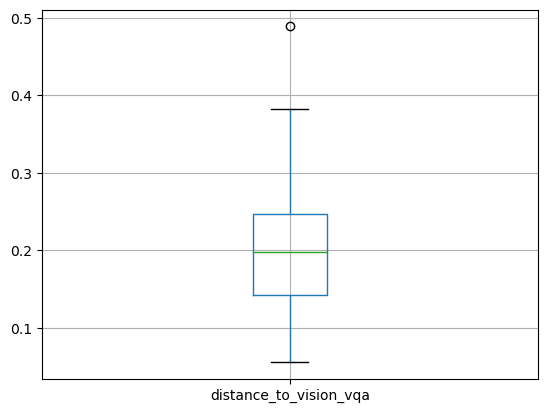

In [4]:
import matplotlib.pyplot as plt

df.boxplot( # rot=90, 
           fontsize=10)
plt.show()

In [5]:
df_low = add_images_thumbnail_to_df(df[:4] )






/Users/julienmiquel/dev/github-capstone-vae/Capstone/src/1_download/src/tools.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['object_name'] = df.uri.map(
/Users/julienmiquel/dev/github-capstone-vae/Capstone/src/1_download/src/tools.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image'] = df.object_name.map(lambda f: get_thumbnail(download_blob(bucket_name, f), size))


In [6]:
df_h = add_images_thumbnail_to_df(df[595:610] )

/Users/julienmiquel/dev/github-capstone-vae/Capstone/src/1_download/src/tools.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['object_name'] = df.uri.map(
/Users/julienmiquel/dev/github-capstone-vae/Capstone/src/1_download/src/tools.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image'] = df.object_name.map(lambda f: get_thumbnail(download_blob(bucket_name, f), size))


,image,distance_to_vision_vqa,attributes_vision,attributes_vc,description_vc
0,,0.055498,"Couch, Property, Furniture, Table, Building, Television, Interior design, Picture frame, House, Living room","Couch, Television, Screen, Living room, Furniture, Fixture, Interior design, Building.",a living room with a couch and a flat screen tv
1,,0.058867,"Table, Furniture, Building, Office chair, Desk, Wood, Architecture, Interior design, Chair, House","Table, Wood, Chair, Room, Furniture, Interior design, Building.",a living room with a large wooden table and black chairs
2,,0.066416,"Mirror, Tap, Plumbing fixture, Sink, Building, Bathroom, Fixture, Wood, Interior design, Bathroom cabinet","Sink, Faucet, Mirror, Cabinetry, Plumbing fixture, Bathroom, Vanity, Water, Tap, Brand.",a bathroom with two sinks and a mirror with a watermark that says okhome.com
3,,0.067000,"Cabinetry, Countertop, Furniture, Building, Kitchen, Sink, Kitchen appliance, Kitchen stove, Drawer, Flooring","Appliance, Countertop, Kitchen, Cabinetry, Sink, Faucet, Building.",a kitchen with progressimmo written on the counter

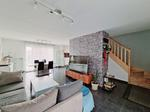
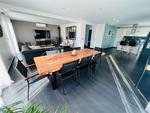
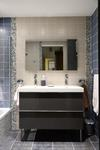
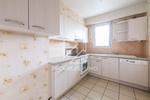

In [9]:
html = df_low[[ 'image', 'distance_to_vision_vqa', 'attributes_vision', 'attributes_vc', 'description_vc' ]].to_html(formatters={'image': image_formatter}, escape=False)

write_html(html)
HTML(html    )

In [8]:

html = df_low[[ 'image', 'distance_to_vision_vqa', 'attributes_vision', 'attributes_vc', 'description_vc' ]].to_html(formatters={'image': image_formatter}, escape=False)

def write_html(html , filename= "output.html"):
    # Creating an HTML file
    with open(filename,"w") as f:

        # Adding input data to the HTML file
        f.write("<html>\n<head>\n<title> \nOutput Data in an HTML file \
                </title>\n</head> <body> " + html  + " </body></html>")



,image,distance_to_vision_vqa,attributes_vision,attributes_vc,description_vc
595,,0.377142,"Font, Electric blue","Poster, Advertisement, Transparency, Simplicity..",a poster for hosman la neo-agence simple et transparente
596,,0.377631,"Building, Table, Wood, House, Interior design, Hall, Flooring, Fixture, Floor, Wall","Game, Table, Number, 11.",a game table with the number 11 on it
597,,0.382367,"Wood, Building, Comfort, Living room, Flooring, House, Floor, Hardwood, Condominium, Laminate flooring","Sign, Room, Mirror.",a room with a large mirror and a sign that says dumarais
598,,0.489100,Font,"Advertisement, Satisfaction, 99%.",an ad for abriculteurs shows a satisfaction rate of 99%

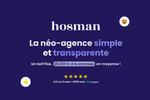
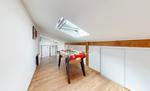
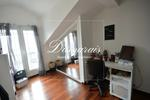
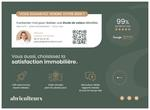

In [39]:
html = df_h[[ 'image', 'distance_to_vision_vqa', 'attributes_vision', 'attributes_vc', 'description_vc' ]].to_html(formatters={'image': image_formatter}, escape=False)
HTML(html)

In [40]:
write_html(html)